# Reconstruction parcimonieuse ou compressive sensing

## I. Cadre général et première tentative.

Le but du TP est de montrer que des techniques d'optimisation pour le Machine Learning permettent de récupérer des signaux qui admettent dans une certaine base une représentation parcimonieuse, c'est à dire mettant en jeu un faible nombre de coefficients. 

On s'intéresse donc à la reconstruction d'un vecteur $x$ (ici une image codées en niveaux de gris) en utilisant les valeurs de combinaisons aléatoire de certains pixels. Les combinaisons sont représentées par une matrice $\Phi$. 

Une première approche consiste à résoudre le problème $$ \min_x \frac{1}{2} ||\Phi x-y||_2^2$$ pour retrouver l'image.

**Question 1 :** Commenter et compléter le code constituant le reste de la section I.

  Activating project at `~/Cours/S7/Optimisation/Convexe/TP`


   Resolving package versions...


  No Changes to `~/Cours/S7/Optimisation/Convexe/TP/Project.toml`
  No Changes to `~/Cours/S7/Optimisation/Convexe/TP/Manifest.toml`


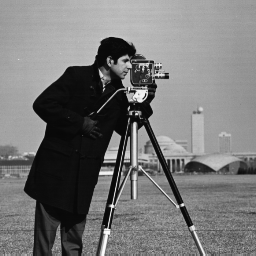

In [1]:
# Installation des librairies
using Pkg
Pkg.activate(".")

# Chargement des librairies de traitement d'image
using Images, Colors, LinearAlgebra, FFTW


img1 = load("cameraman.tif");    # 
img=convert(Array{Gray},img1);   # 
A = convert(Array,img);  # 

tmp=@view img1[:,:]

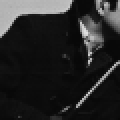

In [2]:
# Extraction d'une sous-image contrastée
k    = 60;
orig = 60;
Aloc   = A[orig:orig+k-1,orig:orig+k-1];
x   = (Aloc[:]);
n   = length(x);
m   = 1000; 
Phi = randn(m,n);

#imhsv=colorview(Gray,float(Aloc));
tmp=@view Aloc[:,:]

**Question 2 :** Résoudre le problème de moindres carrés $$\min_x || \Phi x -y ||_2,$$ et afficher le résultat (attention, l'image doit être en niveaux de gris). Que constate-t-on?

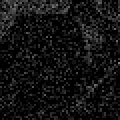

In [3]:
y = Phi*x ; # Vecteur des "observations" de l'image
y = convert.(Float64,y);

# Reconstruction de l'image
x_estimated = pinv(Phi)*y;

# Affichage de l'image originale et de l'image reconstruite
img = reshape(x_estimated,k,k);
img = convert(Array{Gray},img)

#### II. Compressive sensing

On désire utiliser à présent la transformation discrète en cosinus pour obtenir une représentaiton parcimonieuse d'une image. Cette transfomation bijective est obtenue avec la fonction `dct`, son inverse s'appelant `idct`.

A partir de la fonction IDCT de Julia, on calcule la matrice  $\Theta = \Phi*\Psi$, avec $\Psi$ la matrice représentative de IDCT dans la base canonique.


In [4]:
Theta = zeros(m,n);
for ii = 1:n
    ii
    ek = zeros(1,n);
    ek[ii] = 1;
    psi = idct(ek)';
    Theta[:,ii] = Phi*psi;
end

### II.1. Utilisation d'un algorithme de sous-gradient

**Question 3 :** Soit $\lambda > 0$ (ici $\lambda=100$). Expliquer l'intérêt de 
 calculer $x_{sg}= \Psi z$ où $z$ résout $$\min_z \frac{1}{2} ||\Phi  \cdot \Psi  \cdot z -y||_2^2+ \lambda ||z||_1.$$ 

**Réponse :**

**Question 4 :** Justifier la convexité de la fonctionnelle et donner son sous-différentiel.

**Réponse :**

**Question 5 :** Compléter ci-dessous le code de sous-gradient projeté. Vous considèrerez les différents choix de pas $\alpha_i$ vus en cours, et trouverez des réglages permettant d'obtenir un bon rendu visuel. On pourra se rappeler du fait que la solution de norme minimale a une norme inférieure à dix.

In [5]:
z = zeros(k^2, 1)
i = 0
lambda = 1e2
choix_pas = 1  # 1 cas a, 2 cas b, 3 cas c

while i <= 5000
    i = i + 1

    # Calcul du gradient
    grad_f = Theta' * (Theta * z - y) + lambda * sign.(z)

    # Choix du pas
    if choix_pas == 1
        alpha = 1e-5
    elseif choix_pas == 2
        alpha = 1e-2 / i
    elseif choix_pas == 3
        alpha = 1e-2 / norm(grad_f, 2)
    end

    # Mise à jour du vecteur z par sous-gradient
    z = z - alpha * grad_f
end

# Calcul de la norme de la solution obtenue
norm_solution = norm(Theta \ y)

8.177577084241817

**Question 6 :** Expliquer le code suivant et conclure sur l'utilisation du sous-gradient

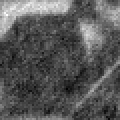

In [6]:
function my_function(n,k,z)
    x2 = zeros(n,1);
    for ii = 1:n
        ii
        ek = zeros(1,n);
        ek[ii] = 1;
        psi = idct(ek)';
        x2 = x2+psi*z[ii];
    end
    x2 = reshape(x2,k,k);
    x2 = 1/(maximum(x2).-minimum(x2))*(x2.-minimum(x2));
    return x2
end
#
x2 = my_function(n,k,z);
imhsv = colorview(Gray, float(x2));
tmp=@view imhsv[:,:]


# II.2. Utilisation d'un algorithme de sous-gradient projeté

**Question 7 :**  Expliquer l'intérêt de 
 calculer $x_{sgp}= \Psi z$ où $z$ résout $$\min_{\Phi  \cdot \Psi  \cdot z =y}  ||z||_1.$$

**Réponse :**

**Question 8 :** Rappeler la formule de la projection sur le convexe $\{x, \Phi  \cdot \Psi  \cdot z =y \}$ vue en cours.

**Réponse :**

**Question 9 :** Résoudre ce problème par l'algorithme de sous-gradient projeté et finaliser le calcul de la solution.

In [7]:
z = zeros(k^2, 1)
i=0;
choix_pas = 3; # 1 cas a, 2 cas b, 3 cas c

#Initialisation (projection de z sur le convexe)
CoefTemp = Theta' * inv(Theta * Theta')
z = CoefTemp * y

while i <= 1000
    i = i + 1; 
    # Calcul du gradient
    grad_f = sign.(z)

    # Choix du pas
    if choix_pas == 1
        alpha = 1e-2
    elseif choix_pas == 2
        alpha = 1 / i
    elseif choix_pas == 3
        alpha = 1 / norm(grad_f, 2)
    end

    # Mise à jour du vecteur z par sous-gradient
    z_temp = z - alpha * grad_f

    # Calcul du projeté
    z = z_temp - CoefTemp * (Theta * z_temp - y)
end

# Calcul de la norme de la solution obtenue
norm_solution = norm(Theta \ y)

8.177577084241817

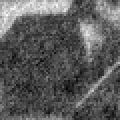

In [8]:
x3 = my_function(n,k,z);
imhsv = colorview(Gray,float(x3));
tmp =@view imhsv[:,:]